# Test beam analysis

### Necessary Imports

In [1]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import norm, moyal
from scipy.signal import find_peaks

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100000

### Read the nTuple data into a Pandas DataFrame

In [16]:
# Define the custom order for the keys
custom_order = [
    'ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R',
    'TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13',
    'TriggerScint',
    'PbGlass',
    'HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14'
]

ntuple_dir = "/Users/jrenner/local/data/beamtest/ntuple_files/"
ntuple_pd_dir = "/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/"
    
def ntuple_to_pd(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}:anaTree".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframe
    df = pd.DataFrame()
    for key in main_keys:
        
        # Skip the nChannels key
        if(key == 'nChannels'):
            continue

        arr = events[key].array(library='np').squeeze()

        # Convert the array to a DataFrame
        df_key = pd.DataFrame(arr)

        # Rename the columns to include the key name
        df_key.columns = [f"{key}{i}" for i in df_key.columns]

        # Concatenate the new DataFrame to the existing one
        df = pd.concat([df, df_key], axis=1)
        
    return df

def ntuple_to_pd_multipeak(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframes for each detector element.
    df_dict = {}
    for key in main_keys:
        
        key_noversion = key.split(';')[0]
        
        # Skip the EventInfo key
        if(key_noversion == 'EventInfo'):
            continue
        
        print("Processing dataframe for",key,"...")
        
        # Get the number of peaks and timestamps
        nPeaks        = events[key]['nPeaks'].array()
        timeStamp     = events[key]['timeStamp'].array()
        triggerTime   = events[key]['triggerTime'].array()
        Pedestal      = events[key]['Pedestal'].array()
        PedestalSigma = events[key]['PedestalSigma'].array()
        PeakVoltage   = events[key]['PeakVoltage'].array()
        PeakTime      = events[key]['PeakTime'].array()
        SignalTime    = events[key]['SignalTime'].array()
        IntCharge     = events[key]['IntCharge'].array()
        
        # Iterate through the array elements and save information for each peak.
        l_evt, l_ipk, l_nPeaks, l_timeStamp, l_triggerTime = [], [], [], [], []
        l_Pedestal, l_PedestalSigma = [], []
        l_PeakVoltage, l_PeakTime, l_SignalTime, l_IntCharge = [], [], [], []
        for evt, (npk, tstamp, ttime, pedestal, spedestal, pkv, pkt, sigt, chg) in enumerate(zip(nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge)):
            
            # Update the lists for each peak.
            if(npk == 0):
                l_evt.append(evt)
                l_ipk.append(-1)
                l_nPeaks.append(npk)
                l_timeStamp.append(tstamp)
                l_triggerTime.append(ttime)
                l_Pedestal.append(pedestal)
                l_PedestalSigma.append(spedestal)
                l_PeakVoltage.append(-1)
                l_PeakTime.append(-1)
                l_SignalTime.append(-1)
                l_IntCharge.append(-1)
            else:
                for ipk in range(npk):
                    l_evt.append(evt)
                    l_ipk.append(ipk)
                    l_nPeaks.append(npk)
                    l_timeStamp.append(tstamp)
                    l_triggerTime.append(ttime)
                    l_Pedestal.append(pedestal)
                    l_PedestalSigma.append(spedestal)
                    l_PeakVoltage.append(pkv[ipk])
                    l_PeakTime.append(pkt[ipk])
                    l_SignalTime.append(sigt[ipk])
                    l_IntCharge.append(chg[ipk])
        
        # Create a new dataframe.
        df = pd.DataFrame({'event':  l_evt,
                           'iPeak': l_ipk,
                           'nPeaks': l_nPeaks,
                           'timeStamp': l_timeStamp,
                           'triggerTime': l_triggerTime,
                           'Pedestal': l_Pedestal,
                           'PedestalSigma': l_PedestalSigma,
                           'PeakVoltage': l_PeakVoltage,
                           'PeakTime': l_PeakTime,
                           'SignalTime': l_SignalTime,
                           'IntCharge': l_IntCharge
                          })

        # Set this as the dataframe or concatenate it to the one that is already there.
        if(key_noversion in df_dict):
            last_evt = df_dict[key_noversion]['event'].values[-1]+1
            df['event'] = df['event'] + last_evt
            print("Concatenating to",key_noversion,"starting with event number",last_evt)
            df_dict[key_noversion] = pd.concat([df_dict[key_noversion], df], ignore_index=True)
        else:
            df_dict[key_noversion] = df
            
    # Add EventInfo information.
    df = pd.DataFrame( {'RunNumber':   events['EventInfo']['RunNumber'].array(library='np'),
                        'EventNumber': events['EventInfo']['EventNumber'].array(library='np'),
                        'SpillNumber': events['EventInfo']['SpillNumber'].array(library='np')})
    df_dict['EventInfo'] = df
        
    return df_dict

def plot_histograms_for_each_signal(df_dict, base_dir=".", rnum = 0, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=60):
    
    out_dir = f"{base_dir}/{rnum}"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    print("Plotting all histograms for",quantity,"for all signals in run",rnum)

    # Create a grid of 8 rows x 4 columns
    fig, axes = plt.subplots(8, 4, figsize=(16, 24))
    flat_axes = axes.ravel()
    
    fig.suptitle(f'Run {rnum}', fontsize=24, y=1.02)

    # Iterate based on the custom order
    for key, ax in zip(custom_order, flat_axes):
        df = df_dict[key]
        
        # Select only non-zero peaks if specified.
        if(select_nonzero_peaks):
            df_select = df[df['nPeaks'] > 0]
        else:
            df_select = df
            
        # Place a cut if we're looking at an HD element and plotting PeakVoltage or IntCharge.
        if(key[0:2] == 'HD' and (quantity == 'IntCharge' or quantity == 'PeakVoltage')):
            df_select = df[df[quantity] > 0.02]

        # Plot histogram for the current signal on its corresponding axis
        n, bins, patches = ax.hist(df_select[quantity], bins=nbins, edgecolor='black', alpha=0.7, label=key)  # capture output to use in legend
        #ax.set_title(key)
        ax.set_xlabel(quantity)
        ax.set_ylabel('Counts/bin')
        ax.legend()  # Add legend
        
        if(logscale):
            ax.set_yscale('log')

    # Adjust the layout so the plots do not overlap
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"{out_dir}/{quantity}.pdf", bbox_inches='tight')
    plt.close()

def read_dataframes_from_csv(directory):
    file_names = os.listdir(directory)
    dfs = {}
    for file in file_names:
        if file.endswith('.csv'):
            key = file.split('.csv')[0]
            dfs[key] = pd.read_csv(os.path.join(directory, file))
    return dfs

def compute_statistics(df):
    
    # Compute average statistics
    avg_nPeaks = df['nPeaks'].mean()
    avg_Pedestal = df['Pedestal'].mean()
    avg_PedestalSigma = df['PedestalSigma'].mean()
    
    # For histograms, bin the data and find the bin with the most counts
    def get_hist_peak(data, bins=100):
        hist, bin_edges = np.histogram(data, bins=bins)
        peak_bin = np.argmax(hist)
        peak_value = (bin_edges[peak_bin] + bin_edges[peak_bin + 1]) / 2
        return peak_value

    peak_PeakVoltage = get_hist_peak(df[df['PeakVoltage'] > 0.2]['PeakVoltage'])
    peak_PeakTime = get_hist_peak(df[df['PeakTime'] > 10]['PeakTime'])
    peak_SignalTime = get_hist_peak(df[df['SignalTime'] > 0.2]['SignalTime'])
    peak_IntCharge = get_hist_peak(df[df['IntCharge'] > 0.025]['IntCharge'])
    
    stats = {
        'avg_nPeaks': avg_nPeaks,
        'avg_Pedestal': avg_Pedestal,
        'avg_PedestalSigma': avg_PedestalSigma,
        'peak_PeakVoltage': peak_PeakVoltage,
        'peak_PeakTime': peak_PeakTime,
        'peak_SignalTime': peak_SignalTime,
        'peak_IntCharge': peak_IntCharge
    }
    
    return stats

def plot_statistics_vs_run(statistics_data, statistic_keys, signal_set, base_dir, signal_set_name):
    
    out_dir = f"{base_dir}/summary"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    n_statistics = len(statistic_keys)
    
    # Define number of rows and columns for the subplots.
    n_cols = 1
    n_rows = math.ceil(n_statistics / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    
    if n_statistics == 1:
        axes = [axes]
        
    # Generate a palette with as many distinct colors as there are signals.
    #palette = sns.color_palette("husl", len(signal_set))
    
    for idx, statistic_key in enumerate(statistic_keys):
        ax = axes[idx]
        #ax = axes[idx//n_cols, idx%n_cols] if n_rows > 1 else axes[idx]
        
        # Set the color cycle for this axis
        #ax.set_prop_cycle(color=palette)
        
        for idkey,key in enumerate(signal_set):
            marker = 's'
            if(idkey > 9): marker = 'o'
            runs = list(statistics_data.keys())
            values = [statistics_data[run][key][statistic_key] for run in runs]
            ax.plot(runs, values, marker=marker, label=key)
        
        #ax.set_title(f"{statistic_key} vs. Run Number")
        ax.set_xlabel("Run Number",fontsize=14)
        ax.set_ylabel(statistic_key,fontsize=14)
        ax.legend()
        ax.grid(True)
    
    # Handle case when the number of plots is odd
    #if n_statistics % 2 != 0 and n_rows > 1:
        #axes[n_rows-1, 1].axis('off')
    #    axes[n_rows-1].axis('off')
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"{out_dir}/{signal_set_name}.pdf", bbox_inches='tight')

### Create dataframes for all runs

In [ ]:
runs = np.arange(630,766)
for run in runs:
    ntuple_file = "{}/ntuple_000{}.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = ntuple_to_pd_multipeak(ntuple_file)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

### Plot all quantities for each signal for each run

In [18]:
runs = np.arange(730,766)
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = read_dataframes_from_csv(run_dir)
    
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
    plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

Computing statistics for run 730
Plotting all histograms for nPeaks for all signals in run 000730
Plotting all histograms for timeStamp for all signals in run 000730
Plotting all histograms for triggerTime for all signals in run 000730
Plotting all histograms for Pedestal for all signals in run 000730
Plotting all histograms for PedestalSigma for all signals in run 000730
Plotting all histograms for PeakVoltage for all signals in run 000730
Plotting all histograms for PeakTime for all signals in run 000730
Plotting all histograms for SignalTime for all signals in run 000730
Plotting all histograms for IntCharge for all signals in run 000730
Computing statistics for run 731
Plotting all histograms for nPeaks for all signals in run 000731
Plotting all histograms for timeStamp for all signals in run 000731
Plotting all histograms for triggerTime for all signals in run 000731
Plotting all histograms for Pedestal for all signals in run 000731
Plotting all histograms for PedestalSigma for al

Plotting all histograms for PeakTime for all signals in run 000742
Plotting all histograms for SignalTime for all signals in run 000742
Plotting all histograms for IntCharge for all signals in run 000742
Computing statistics for run 743
Plotting all histograms for nPeaks for all signals in run 000743
Plotting all histograms for timeStamp for all signals in run 000743
Plotting all histograms for triggerTime for all signals in run 000743
Plotting all histograms for Pedestal for all signals in run 000743
Plotting all histograms for PedestalSigma for all signals in run 000743
Plotting all histograms for PeakVoltage for all signals in run 000743
Plotting all histograms for PeakTime for all signals in run 000743
Plotting all histograms for SignalTime for all signals in run 000743
Plotting all histograms for IntCharge for all signals in run 000743
Computing statistics for run 744
Plotting all histograms for nPeaks for all signals in run 000744
Plotting all histograms for timeStamp for all sig

Plotting all histograms for Pedestal for all signals in run 000763
Plotting all histograms for PedestalSigma for all signals in run 000763
Plotting all histograms for PeakVoltage for all signals in run 000763
Plotting all histograms for PeakTime for all signals in run 000763
Plotting all histograms for SignalTime for all signals in run 000763
Plotting all histograms for IntCharge for all signals in run 000763
Computing statistics for run 764
Plotting all histograms for nPeaks for all signals in run 000764
Plotting all histograms for timeStamp for all signals in run 000764
Plotting all histograms for triggerTime for all signals in run 000764
Plotting all histograms for Pedestal for all signals in run 000764
Plotting all histograms for PedestalSigma for all signals in run 000764
Plotting all histograms for PeakVoltage for all signals in run 000764
Plotting all histograms for PeakTime for all signals in run 000764
Plotting all histograms for SignalTime for all signals in run 000764
Plotti

## Compute and plot statistics for each run

In [19]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = compute_statistics(df_dict[key])

Computing statistics for run 730
Computing statistics for run 731
Computing statistics for run 732
Computing statistics for run 733
Computing statistics for run 734
Computing statistics for run 735
Computing statistics for run 736
Computing statistics for run 737
Computing statistics for run 738
Computing statistics for run 739
Computing statistics for run 740
Computing statistics for run 741
Computing statistics for run 742
Computing statistics for run 743
Computing statistics for run 744
Computing statistics for run 745
Computing statistics for run 746
Computing statistics for run 747
Computing statistics for run 748
Computing statistics for run 749
Computing statistics for run 753
Computing statistics for run 754
Computing statistics for run 755
Computing statistics for run 756
Computing statistics for run 760
Computing statistics for run 763
Computing statistics for run 764
Computing statistics for run 765


#### Plot summary statistics from each run

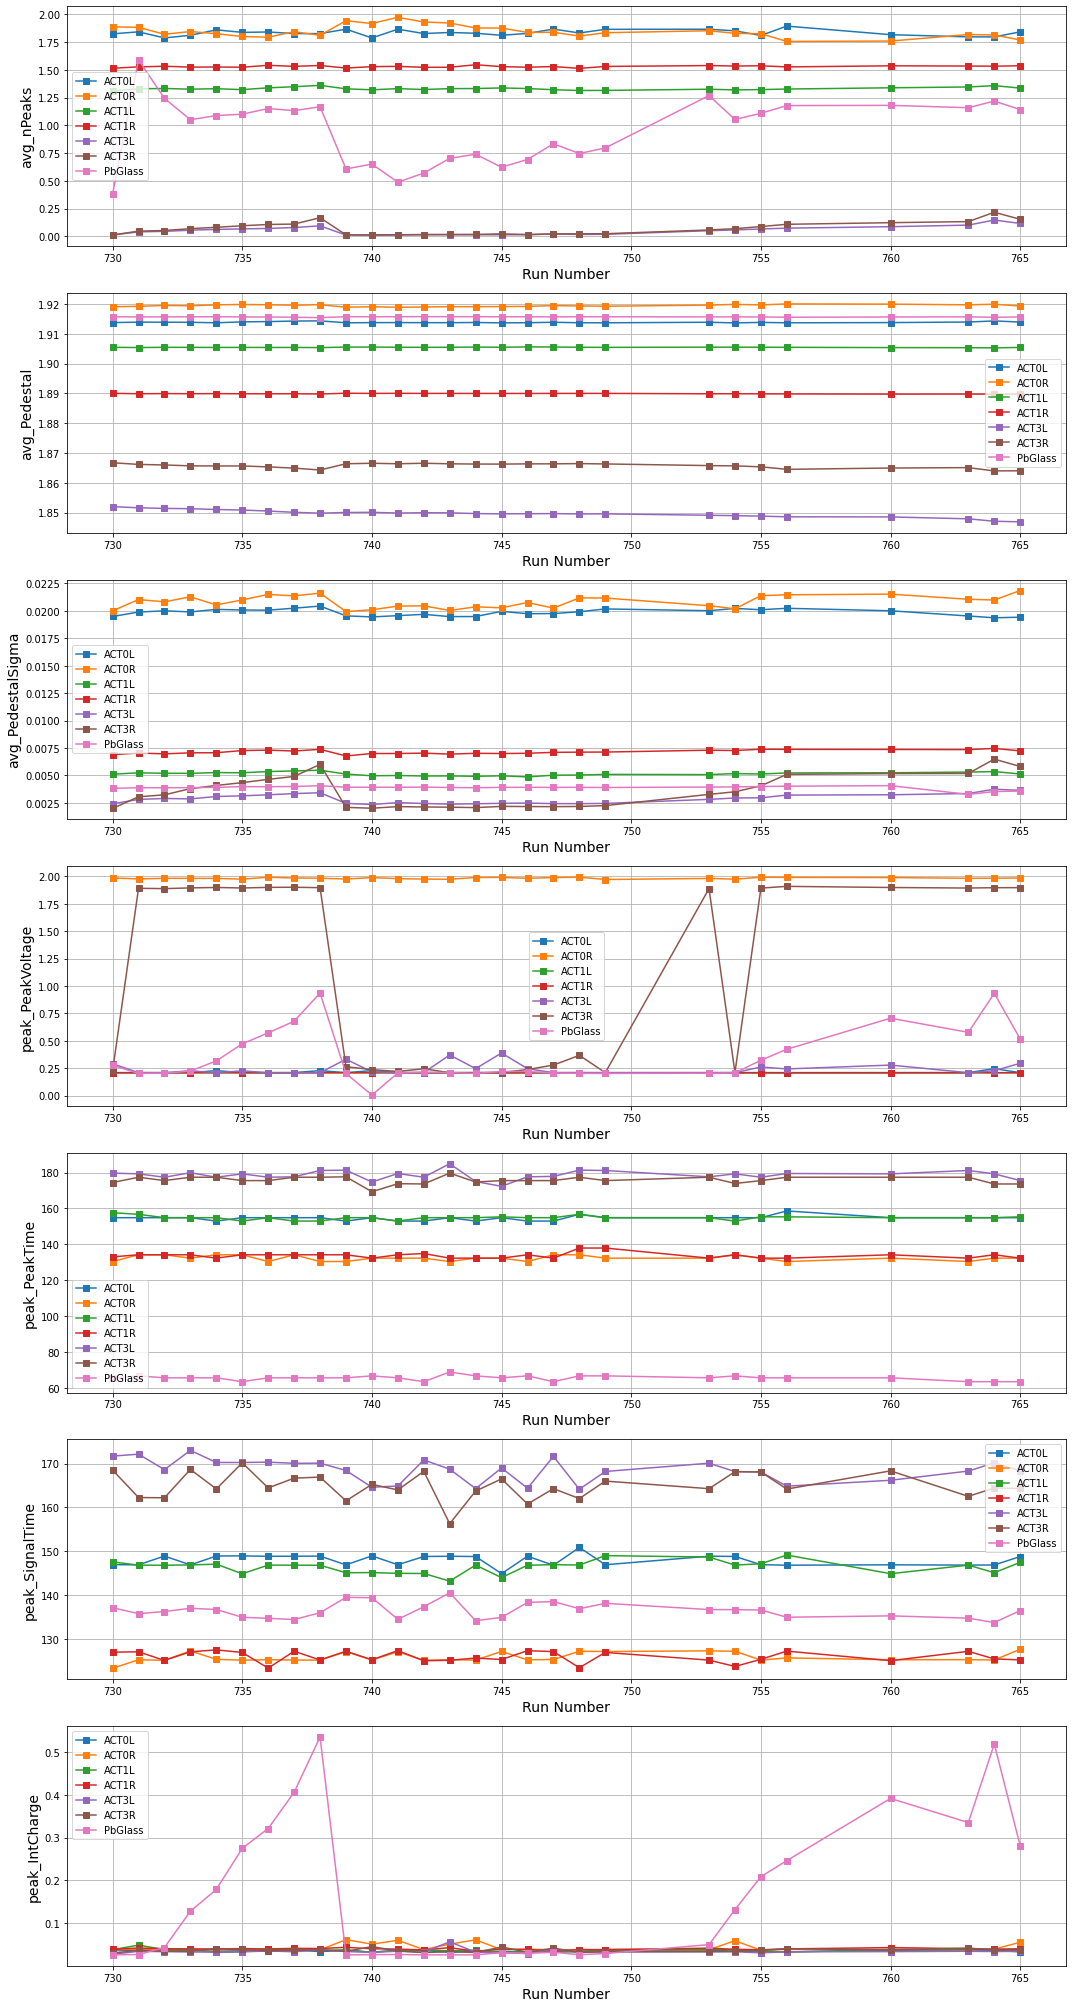

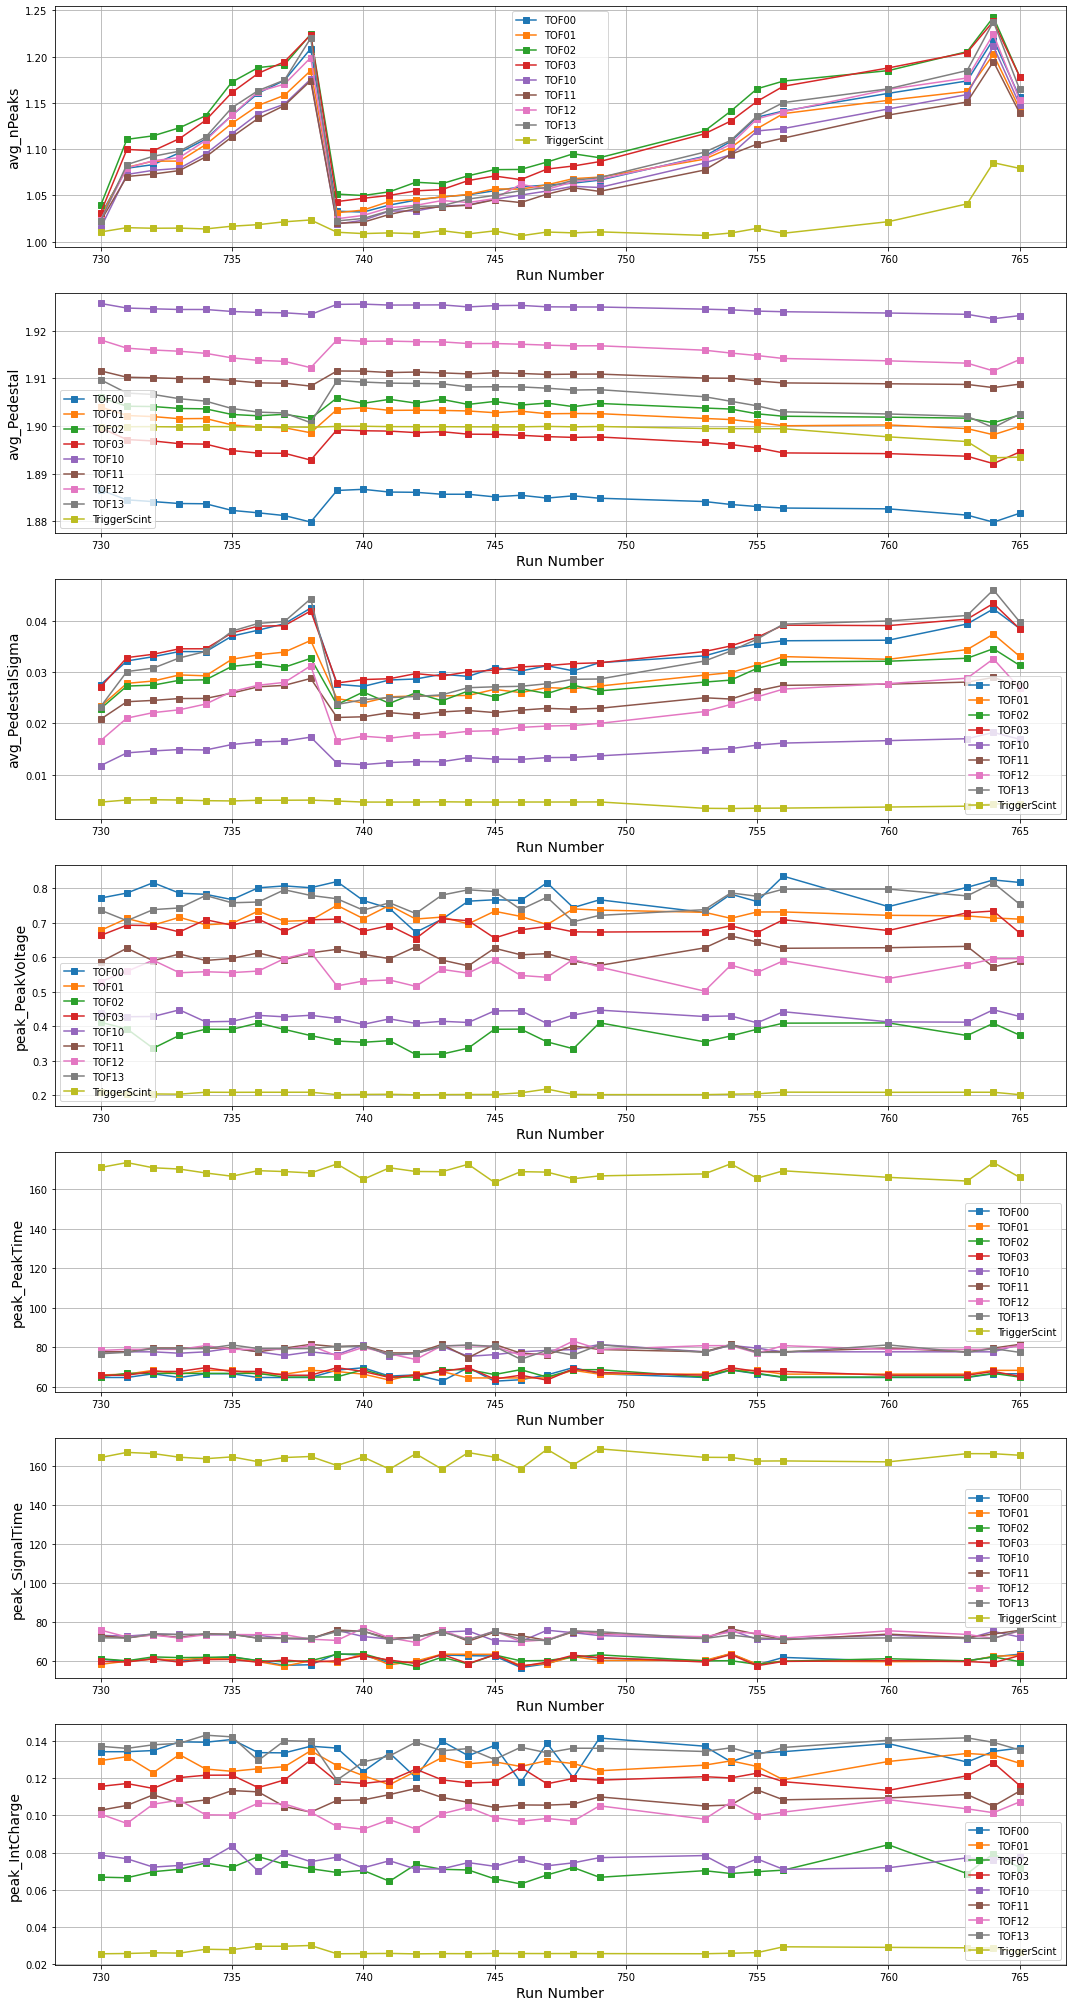

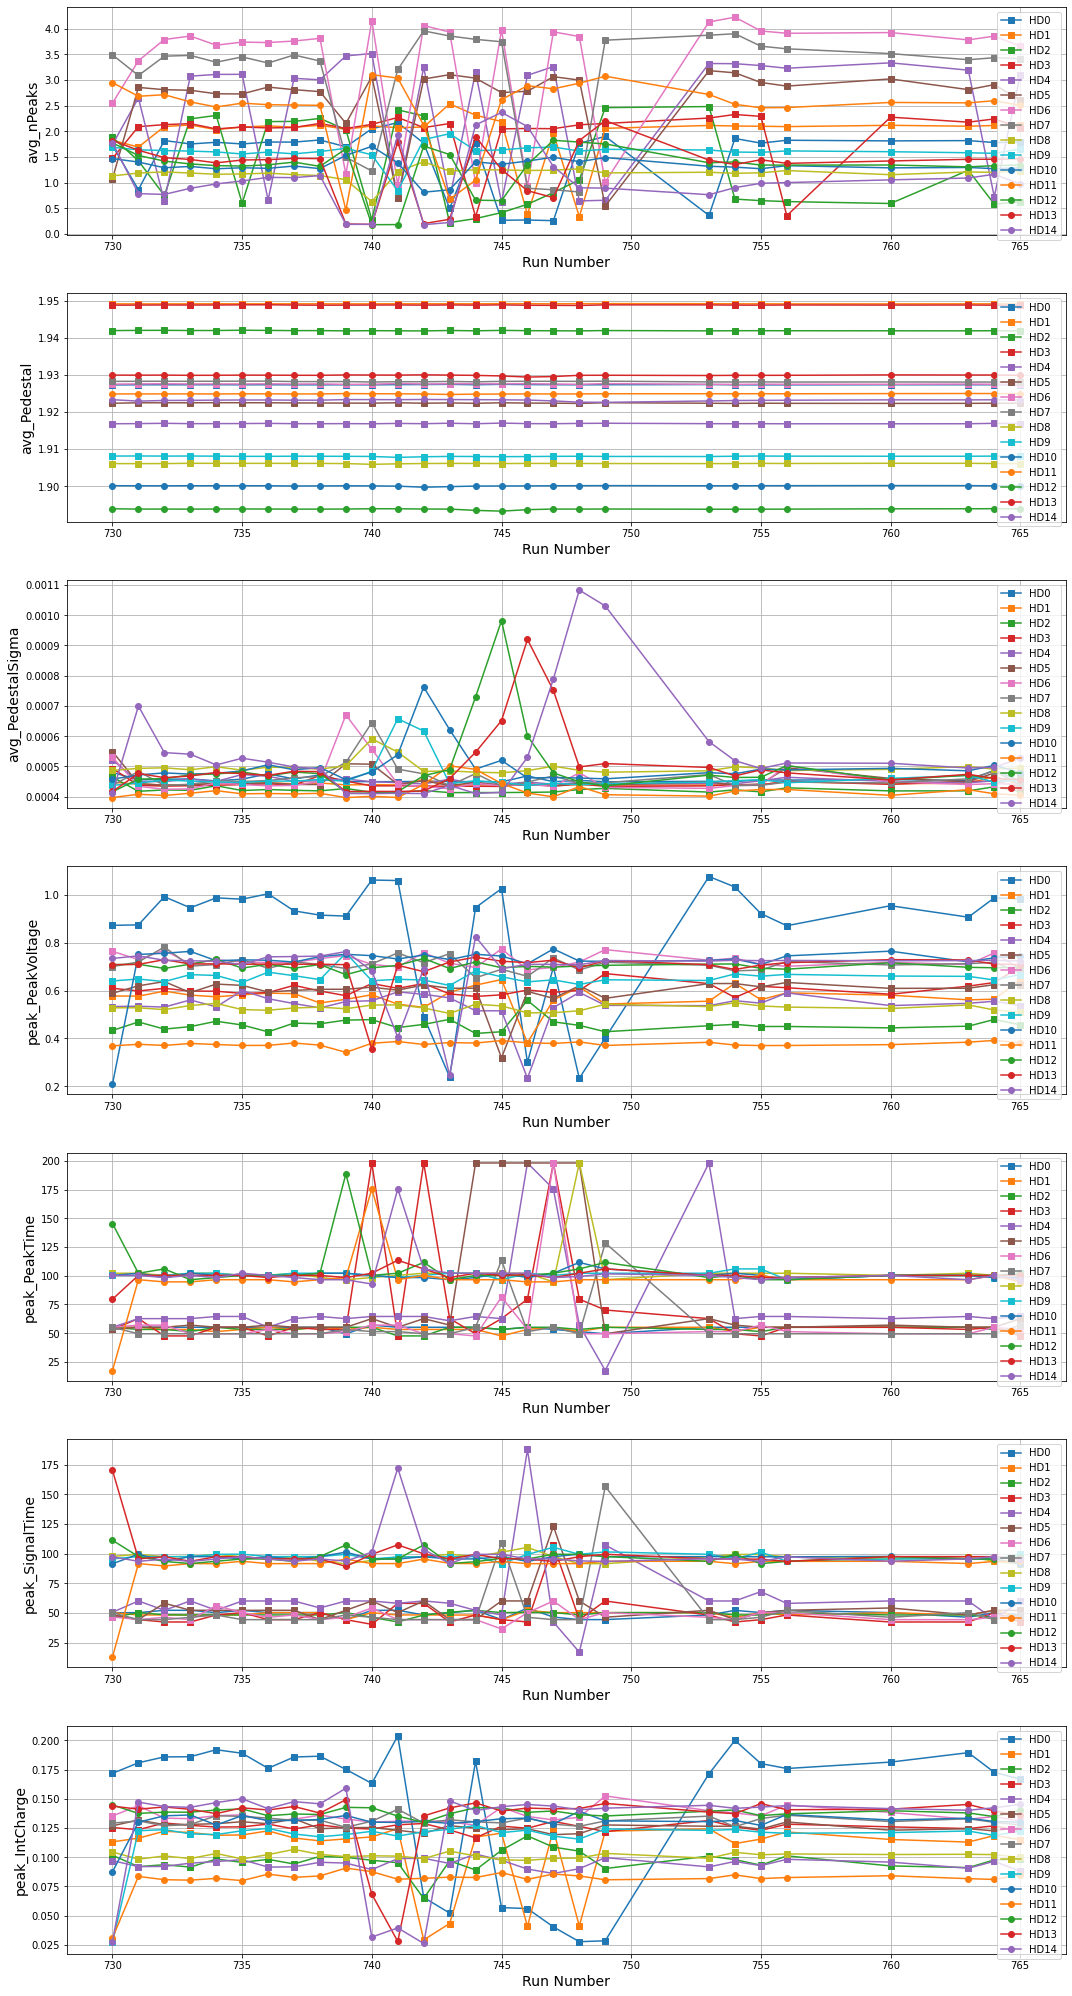

In [20]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

# Gamma peak analysis

In [21]:
def get_num_duplicates(arr):
    u, c = np.unique(arr, return_counts=True)
    return np.sum(c[c > 1])

def filter_range(name,df,key,rng,drop=False):
    
    # Perform the filter.
    df_filtered = df[df[key].between(*rng)]
    nduplicates = get_num_duplicates(df_filtered['event'].values)
    print(f"{name} filter passed",len(df_filtered),"of",len(df),"with",nduplicates,"duplicates")
    
    # Handle duplicates.
    if(nduplicates > 0):
        
        # Drop all events that appear more than once if selected.
        if(drop):
            df_filtered = df_filtered[~df_filtered['event'].duplicated(keep=False)]
        # Otherwise choose the one with the maximum integrated charge.
        else:
            idx = df_filtered.groupby('event')['IntCharge'].idxmax()
            df_filtered = df_filtered.loc[idx]
        
    print("--> returning",len(df_filtered),"events")
    return df_filtered

In [22]:
# Read in all dataframes from a given run
df_dict = read_dataframes_from_csv("/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/run000734")
df_dict.keys()

dict_keys(['EventInfo', 'ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

In [129]:
# Filter 'PbGlass' Peaks Based on Timing
pb_timing_range = (45, 75)
pb_filtered = filter_range("PbGlass",df_dict['PbGlass'],'PeakTime',pb_timing_range)

PbGlass filter passed 21386 of 27641 with 556 duplicates
--> returning 21096 events


In [130]:
# Filter TOF elements
tof0_timing_range = (45, 85)
tof0_charge_range = (0.3, 1.0)
tof1_timing_range = (60, 100)
tof1_charge_range = (0.3, 1.0)
t2_timing_range = (160, 180)
t2_charge_range = (0.01, 0.0225)

# TOF0
tof00_filtered = filter_range("TOF00",df_dict['TOF00'],'PeakTime',tof0_timing_range)
tof01_filtered = filter_range("TOF01",df_dict['TOF01'],'PeakTime',tof0_timing_range)
tof02_filtered = filter_range("TOF02",df_dict['TOF02'],'PeakTime',tof0_timing_range)
tof03_filtered = filter_range("TOF03",df_dict['TOF03'],'PeakTime',tof0_timing_range)

combined_00_01 = tof00_filtered.merge(tof01_filtered, on='event', suffixes=('_00', '_01'))
combined_00_01_02 = combined_00_01.merge(tof02_filtered, on='event')
combined_00_01_02 = combined_00_01_02.rename(columns={'IntCharge': 'IntCharge_02'})
tof0_combined = combined_00_01_02.merge(tof03_filtered, on='event')
tof0_combined = tof0_combined.rename(columns={'IntCharge': 'IntCharge_03'})
tof0_combined['combined_charge'] = (tof0_combined['IntCharge_00'] 
                                  + tof0_combined['IntCharge_01']
                                  + tof0_combined['IntCharge_02']
                                  + tof0_combined['IntCharge_03'])

tof0_valid = filter_range("TOF0_combined",tof0_combined,'combined_charge',tof0_charge_range)
tof0_valid.loc[:,'hit_TOF0'] = 1
print()

# TOF1
tof10_filtered = filter_range("TOF10",df_dict['TOF10'],'PeakTime',tof1_timing_range)
tof11_filtered = filter_range("TOF11",df_dict['TOF11'],'PeakTime',tof1_timing_range)
tof12_filtered = filter_range("TOF12",df_dict['TOF12'],'PeakTime',tof1_timing_range)
tof13_filtered = filter_range("TOF13",df_dict['TOF13'],'PeakTime',tof1_timing_range)

combined_10_11 = tof10_filtered.merge(tof11_filtered, on='event', suffixes=('_10', '_11'))
combined_10_11_12 = combined_10_11.merge(tof12_filtered, on='event')
combined_10_11_12 = combined_10_11_12.rename(columns={'IntCharge': 'IntCharge_12'})
tof1_combined = combined_10_11_12.merge(tof13_filtered, on='event')
tof1_combined = tof1_combined.rename(columns={'IntCharge': 'IntCharge_13'})
tof1_combined['combined_charge'] = (tof1_combined['IntCharge_10'] 
                                  + tof1_combined['IntCharge_11']
                                  + tof1_combined['IntCharge_12']
                                  + tof1_combined['IntCharge_13'])

tof1_valid = filter_range("TOF1_combined",tof1_combined,'combined_charge',tof1_charge_range)
tof1_valid.loc[:,'hit_TOF1'] = 1
print()

# T2
t2_filtered = filter_range("T2",df_dict['TriggerScint'],'PeakTime',t2_timing_range)
t2_valid = filter_range("T2",t2_filtered,'IntCharge',t2_charge_range)
t2_valid.loc[:,'hit_T2'] = 1
print()

TOF00 filter passed 25860 of 27013 with 612 duplicates
--> returning 25553 events
TOF01 filter passed 25722 of 26955 with 370 duplicates
--> returning 25537 events
TOF02 filter passed 25731 of 27289 with 444 duplicates
--> returning 25509 events
TOF03 filter passed 25877 of 27265 with 633 duplicates
--> returning 25560 events
TOF0_combined filter passed 24365 of 25456 with 0 duplicates
--> returning 24365 events

TOF10 filter passed 25722 of 26823 with 368 duplicates


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


--> returning 25538 events
TOF11 filter passed 25735 of 26760 with 354 duplicates
--> returning 25558 events
TOF12 filter passed 25732 of 26998 with 410 duplicates
--> returning 25527 events
TOF13 filter passed 25704 of 27038 with 374 duplicates
--> returning 25517 events
TOF1_combined filter passed 24177 of 25466 with 0 duplicates
--> returning 24177 events

T2 filter passed 25144 of 25769 with 2 duplicates
--> returning 25143 events
T2 filter passed 17449 of 25143 with 0 duplicates
--> returning 17449 events



In [131]:
# Filter the ACT elements
act0_timing_range = (130, 175)
act0_charge_range = (0.1, 1.0)
act1_timing_range = (130, 175)
act1_charge_range = (0.02, 0.2)
act3_timing_range = (150, 190)

# ACT0
act0l_filtered = filter_range("ACT0L",df_dict['ACT0L'],'PeakTime',act0_timing_range)
act0r_filtered = filter_range("ACT0R",df_dict['ACT0R'],'PeakTime',act0_timing_range)

act0_combined = act0l_filtered.merge(act0r_filtered, on='event', suffixes=('_L', '_R'))
act0_combined['combined_charge'] = act0_combined['IntCharge_L'] + act0_combined['IntCharge_R']

act0_valid = filter_range("ACT0_combined",act0_combined,'combined_charge',act0_charge_range)
act0_valid.loc[:,'hit_ACT0'] = 1

# ACT1
act1l_filtered = filter_range("ACT1L",df_dict['ACT1L'],'PeakTime',act1_timing_range)
act1r_filtered = filter_range("ACT1R",df_dict['ACT1R'],'PeakTime',act1_timing_range)

act1_combined = act1l_filtered.merge(act1r_filtered, on='event', suffixes=('_L', '_R'))
act1_combined['combined_charge'] = act1_combined['IntCharge_L'] + act1_combined['IntCharge_R']

act1_valid = filter_range("ACT1_combined",act1_combined,'combined_charge',act1_charge_range)
act1_valid.loc[:,'hit_ACT1'] = 1

# ACT3
act3l_filtered = df_dict['ACT3L'][df_dict['ACT3L']['nPeaks'] == 0]
act3r_filtered = df_dict['ACT3R'][df_dict['ACT3R']['nPeaks'] == 0]

act3_combined = act3l_filtered.merge(act3r_filtered, on='event', suffixes=('_L', '_R'))
act3_valid = act3_combined.copy()
act3_valid.loc[:,'nohit_ACT3'] = 1
print("ACT3 total number of valid events:",len(act3_valid))

ACT0L filter passed 28090 of 38560 with 8844 duplicates
--> returning 23541 events
ACT0R filter passed 23696 of 35969 with 7559 duplicates
--> returning 19837 events
ACT0_combined filter passed 16633 of 18267 with 0 duplicates
--> returning 16633 events
ACT1L filter passed 23444 of 31360 with 2684 duplicates
--> returning 22095 events
ACT1R filter passed 22078 of 33864 with 5149 duplicates
--> returning 19490 events
ACT1_combined filter passed 15719 of 16837 with 0 duplicates
--> returning 15719 events
ACT3 total number of valid events: 23634


In [132]:
# Filter hodoscope elements
hd_dfs = {}
hd_timing_ranges = {
    'HD0': (35, 75),
    'HD1': (35, 75),
    'HD2': (35, 75),
    'HD3': (35, 75),
    'HD4': (35, 75),
    'HD5': (35, 75),
    'HD6': (35, 75),
    'HD7': (35, 75),
    'HD8': (80, 120),
    'HD9': (80, 120),
    'HD10': (80, 120),
    'HD11': (80, 120),
    'HD12': (80, 120),
    'HD13': (80, 120),
    'HD14': (80, 120)
}
hd_charge_ranges = {
    'HD0': (0.12, 0.3),
    'HD1': (0.09, 0.2),
    'HD2': (0.06, 0.15),
    'HD3': (0.075, 0.2),
    'HD4': (0.075, 0.2),
    'HD5': (0.1, 0.3),
    'HD6': (0.1, 0.3),
    'HD7': (0.1, 0.3),
    'HD8': (0.085, 0.285),
    'HD9': (0.085, 0.285),
    'HD10': (0.1, 0.3),
    'HD11': (0.075, 0.275),
    'HD12': (0.1, 0.3),
    'HD13': (0.1, 0.4),
    'HD14': (0.1, 0.4)    
}

# Create the filtered dataframes (containing peaks over the threshold at the correct time).
for i in range(15):  # 0 to 14 inclusive
    hd_key = f'HD{i}'
    hit_col_name = f'hit_{hd_key}'
    hd_time_range = hd_timing_ranges[hd_key]
    hd_charge_range = hd_charge_ranges[hd_key]
    
    # Filtering
    filtered = df_dict[hd_key][(df_dict[hd_key]['PeakTime'].between(*hd_time_range)) & 
                               (df_dict[hd_key]['IntCharge'].between(*hd_charge_range))]
    print(f"HD{i}: {len(filtered)} of {len(df_dict[hd_key])} events after filter")
    
    # Assign a binary value indicating a hit
    if not filtered.empty:
        filtered.loc[:,hit_col_name] = 1
    else:
        filtered.loc[:,hit_col_name] = 0

    hd_dfs[hd_key] = filtered

# Merge all HD dataframes
combined_hd_df = hd_dfs['HD0'][['event', 'hit_HD0']]
for i in range(1, 15):
    hd_key = f'HD{i}'
    hit_col_name = f'hit_{hd_key}'
    
    combined_hd_df = combined_hd_df.merge(
        hd_dfs[hd_key][['event', hit_col_name]],
        on='event',
        how='outer'
    ).fillna(0)

# Calculate total hits per event
combined_hd_df['total_hits'] = combined_hd_df.filter(like='hit_').sum(axis=1)

# Filter events with a hit count of 1
hd_valid_events = combined_hd_df[combined_hd_df['total_hits'] == 1]

u, c = np.unique(combined_hd_df['event'].values, return_counts=True)
print("Duplicates in combined HD dataframe:",np.sum(c[c > 1]))

HD0: 141 of 36254 events after filter
HD1: 177 of 39155 events after filter
HD2: 238 of 41612 events after filter
HD3: 372 of 38405 events after filter
HD4: 461 of 45730 events after filter
HD5: 607 of 42912 events after filter
HD6: 742 of 50302 events after filter
HD7: 981 of 46568 events after filter
HD8: 1242 of 31683 events after filter
HD9: 1637 of 34758 events after filter
HD10: 2078 of 32040 events after filter
HD11: 2420 of 40646 events after filter
HD12: 3299 of 32271 events after filter
HD13: 4300 of 32365 events after filter
HD14: 6736 of 28601 events after filter
Duplicates in combined HD dataframe: 0


In [133]:
# Merge all relevant dataframes
final_df = pb_filtered.merge(hd_valid_events, on='event', how='inner')
final_df = final_df.merge(act0_valid[['event', 'hit_ACT0']], on='event', how='left')
final_df = final_df.merge(act1_valid[['event', 'hit_ACT1']], on='event', how='left')
final_df = final_df.merge(act3_valid[['event', 'nohit_ACT3']], on='event', how='left')
final_df = final_df.merge(tof0_valid[['event', 'hit_TOF0']], on='event', how='left')
final_df = final_df.merge(tof1_valid[['event', 'hit_TOF1']], on='event', how='left')
final_df = final_df.merge(t2_valid[['event', 'hit_T2']], on='event', how='left')

# Fill NaN values in the hit columns with 0
final_df[['hit_ACT0', 'hit_ACT1', 'nohit_ACT3', 'hit_TOF0', 'hit_TOF1', 'hit_T2']] = final_df[['hit_ACT0', 'hit_ACT1', 'nohit_ACT3', 'hit_TOF0', 'hit_TOF1', 'hit_T2']].fillna(0)

In [134]:
final_df.head(100)

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge,hit_HD0,hit_HD1,hit_HD2,hit_HD3,hit_HD4,hit_HD5,hit_HD6,hit_HD7,hit_HD8,hit_HD9,hit_HD10,hit_HD11,hit_HD12,hit_HD13,hit_HD14,total_hits,hit_ACT0,hit_ACT1,nohit_ACT3,hit_TOF0,hit_TOF1,hit_T2
0,0,0,1,1690841966,486812803,1.915855,0.002953,0.469149,57.0,128.139771,0.286325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,1,0,1,1690841966,487927507,1.915355,0.003188,0.570149,57.0,129.208293,0.235422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,0,1,1690841966,487997623,1.915275,0.003824,0.522894,73.0,144.483146,0.287692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,4,0,2,1690841966,492064009,1.915641,0.003977,0.011379,59.0,134.715478,0.000455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,5,0,1,1690841966,492143061,1.915776,0.004847,0.643709,55.0,127.305408,0.288816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
5,6,0,1,1690841966,492231399,1.915495,0.004154,0.399025,63.0,131.959575,0.228550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
6,7,0,1,1690841966,492368493,1.916002,0.003971,0.586831,65.0,134.521891,0.337461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7,8,0,1,1690841966,492548633,1.915892,0.005288,0.292559,63.0,133.641100,0.153630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
8,9,0,1,1690841966,492627651,1.916105,0.003367,0.309568,69.0,139.088791,0.183658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
9,10,0,1,1690841966,492634193,1.916176,0.002727,0.286748,55.0,126.229099,0.153372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


H14 with 1820 events and 73 tail events


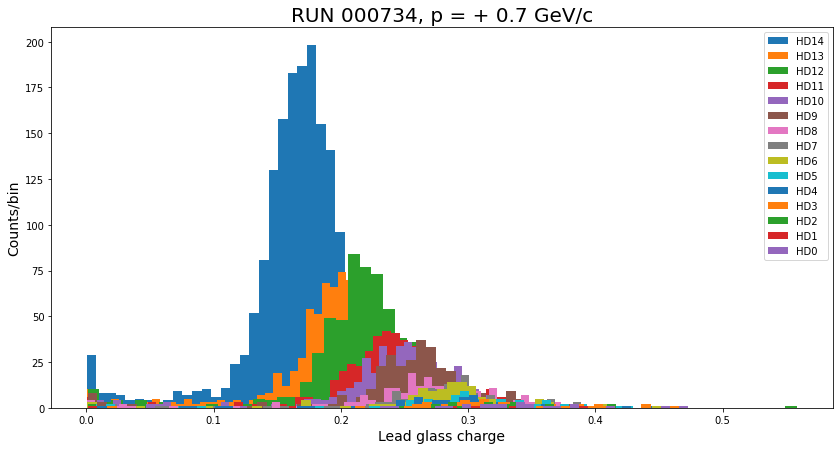

In [135]:
cuts_all = (final_df.total_hits == 1) & (final_df.hit_ACT0 == 1) & \
           (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
           (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)
nbins = 60

cuts = cuts_all

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts]['IntCharge'],bins=nbins,label="HD14")
print("H14 with",len(final_df[(final_df.hit_HD14 == 1) & cuts]),"events",
     "and",len(final_df[(final_df.hit_HD14 == 1) & cuts & (final_df.IntCharge < 0.1) & (final_df.IntCharge > 0.01)]),"tail events")
plt.hist(final_df[(final_df.hit_HD13 == 1) & cuts]['IntCharge'],bins=nbins,label="HD13")
plt.hist(final_df[(final_df.hit_HD12 == 1) & cuts]['IntCharge'],bins=nbins,label="HD12")
plt.hist(final_df[(final_df.hit_HD11 == 1) & cuts]['IntCharge'],bins=nbins,label="HD11")
plt.hist(final_df[(final_df.hit_HD10 == 1) & cuts]['IntCharge'],bins=nbins,label="HD10")
plt.hist(final_df[(final_df.hit_HD9 == 1) & cuts]['IntCharge'],bins=nbins,label="HD9")
plt.hist(final_df[(final_df.hit_HD8 == 1) & cuts]['IntCharge'],bins=nbins,label="HD8")
plt.hist(final_df[(final_df.hit_HD7 == 1) & cuts]['IntCharge'],bins=nbins,label="HD7")
plt.hist(final_df[(final_df.hit_HD6 == 1) & cuts]['IntCharge'],bins=nbins,label="HD6")
plt.hist(final_df[(final_df.hit_HD5 == 1) & cuts]['IntCharge'],bins=nbins,label="HD5")
plt.hist(final_df[(final_df.hit_HD4 == 1) & cuts]['IntCharge'],bins=nbins,label="HD4")
plt.hist(final_df[(final_df.hit_HD3 == 1) & cuts]['IntCharge'],bins=nbins,label="HD3")
plt.hist(final_df[(final_df.hit_HD2 == 1) & cuts]['IntCharge'],bins=nbins,label="HD2")
plt.hist(final_df[(final_df.hit_HD1 == 1) & cuts]['IntCharge'],bins=nbins,label="HD1")
plt.hist(final_df[(final_df.hit_HD0 == 1) & cuts]['IntCharge'],bins=nbins,label="HD0")
plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()
#plt.yscale('log')

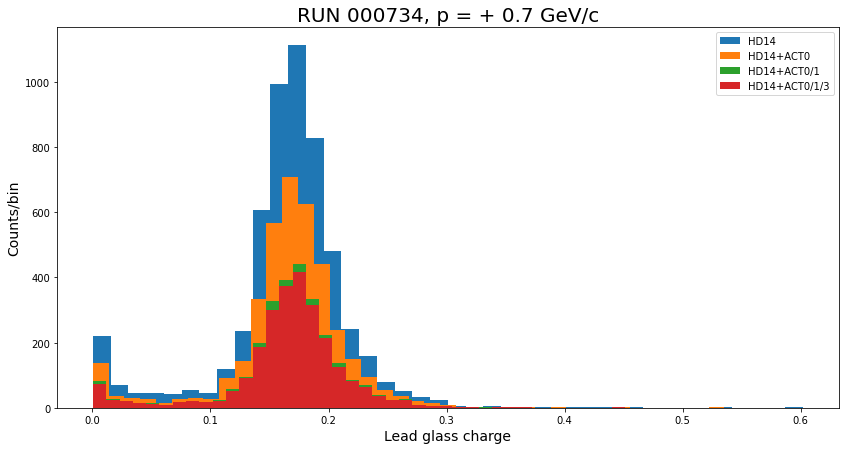

In [136]:
cuts_all = (final_df.total_hits == 1) 
cuts_ACT0 = cuts_all & (final_df.hit_ACT0 == 1)
cuts_ACT1 = cuts_ACT0 & (final_df.hit_ACT1 == 1)
cuts_ACT3 = cuts_ACT1 & (final_df.nohit_ACT3 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT0]['IntCharge'],bins=40,label="HD14+ACT0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT1]['IntCharge'],bins=40,label="HD14+ACT0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT3]['IntCharge'],bins=40,label="HD14+ACT0/1/3")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

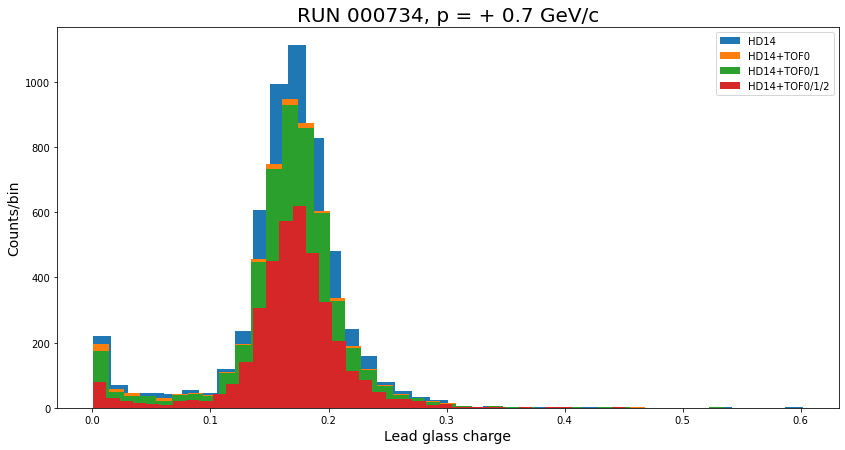

In [137]:
cuts_all = (final_df.total_hits == 1) 
cuts_TOF0 = cuts_all & (final_df.hit_TOF0 == 1)
cuts_TOF1 = cuts_TOF0 & (final_df.hit_TOF1 == 1)
cuts_T2 = cuts_TOF1 & (final_df.hit_T2 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF0]['IntCharge'],bins=40,label="HD14+TOF0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF1]['IntCharge'],bins=40,label="HD14+TOF0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_T2]['IntCharge'],bins=40,label="HD14+TOF0/1/2")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

(array([2.000e+00, 6.000e+00, 2.000e+00, 5.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        4.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 6.000e+00, 5.000e+00, 4.000e+00,
        3.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 5.000e+00, 5.000e+00,
        5.000e+00, 5.000e+00, 6.000e+00, 0.000e+00, 7.000e+00, 8.000e+00,
        6.000e+00, 7.000e+00, 7.000e+00, 6.000e+00, 3.000e+00, 7.000e+00,
        9.000e+00, 1.300e+01, 9.000e+00, 1.500e+01, 1.500e+01, 1.300e+01,
        1.100e+01, 0.000e+00, 1.100e+01, 1.400e+01, 7.000e+00, 1.500e+01,
        1.500e+01, 2.200e+01, 1.900e+01, 1.800e+01, 2.900e+01, 2.100e+01,
        2.600e+01, 2.800e+01, 4.700e+01, 5.400e+01, 5.700e+01, 7.800e+01,
        0.000e+00, 1.270e+02, 2.390e+02, 5.190e+02, 7.210e+02, 1.078e+03,
        1.288e+03, 1.592e+03, 1.759e+03, 1.964e+03, 2.084e+03, 1.917e+03,
        1.737e+03, 1.644e+03, 1.419e+0

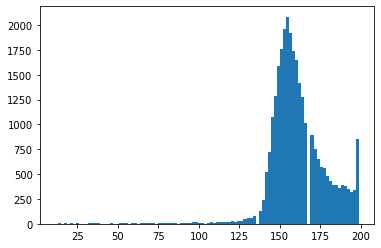

In [138]:
#plt.hist(df_dict['ACT3L'][df_dict['ACT3L']['PeakTime'] > 10]['PeakTime'],bins=100)
plt.hist(df_dict['ACT1L'][df_dict['ACT1L']['PeakTime'] > 10]['PeakTime'],bins=100)
#plt.hist(act0_combined['combined_charge'],bins=100)

In [ ]:
plt.hist(tof1_combined['combined_charge'],bins=100,range=[0,1])
#plt.hist(df_dict['TOF00']['PeakTime'],bins=100,range=[35,90])
#plt.hist(df_dict['TriggerScint']['IntCharge'],bins=100,range=[0,0.05])

In [ ]:
events = uproot.open("{}".format("../ntuples/ntuple_000734.root"))
main_keys = events.keys()

In [ ]:
dataframes

## Single-peak analysis

### Runs 670 - 677: Trigger T0 and T2 Coincidence with Hodoscope OR Lead Glass - 1% Slit
#### Please note that ntuples 672 (700 MeV), 674 (900 MeV), 675 (1 GeV) and 716 (700 MeV) cannot be produced with Nick script. This is something that may need to be considered.

In [ ]:
# Convert the ROOT file to a CSV
run  = "000734"
path = "../ntuples/ntuple_"
df   = ntuple_to_pd(path + "{}.root".format(run))

In [ ]:
df.head(100)

## Peak time analysis

In [ ]:
# Create entries in dataframe for averages in peak times
df['PeakTimeACT0'] = (df['PeakTime0'] + df['PeakTime1'])/2
df['PeakTimeACT1'] = (df['PeakTime2'] + df['PeakTime3'])/2
df['PeakTimeACT3'] = (df['PeakTime4'] + df['PeakTime5'])/2
df['PeakVoltageACT3'] = (df['PeakVoltage4'] + df['PeakVoltage5'])/2
df['PeakTimeTOF0'] = (df['PeakTime8'] + df['PeakTime9'] + df['PeakTime10'] + df['PeakTime11'])/4
df['PeakTimeTOF1'] = (df['PeakTime12'] + df['PeakTime13'] + df['PeakTime14'] + df['PeakTime15'])/4

In [ ]:
rng_time = [0,200]
nbins_time = 100

fig = plt.figure(figsize=(18,7))

h_ACT0R = plt.hist(df['PeakTime0'],bins=nbins_time,range=rng_time,label="ACT0-R")
h_ACT0L = plt.hist(df['PeakTime1'],bins=nbins_time,range=rng_time,label="ACT0-L")
h_ACT1L = plt.hist(df['PeakTime2'],bins=nbins_time,range=rng_time,label="ACT1-R")
h_ACT1R = plt.hist(df['PeakTime3'],bins=nbins_time,range=rng_time,label="ACT1-L")
h_ACT3L = plt.hist(df['PeakTime4'],bins=nbins_time,range=rng_time,label="ACT3-R")
h_ACT3R = plt.hist(df['PeakTime5'],bins=nbins_time,range=rng_time,label="ACT3-L")

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="Trigger scintillator")

h_TOF00 = plt.hist(df['PeakTime8'],bins=nbins_time,range=rng_time,label='TOF0-0')
h_TOF01 = plt.hist(df['PeakTime9'],bins=nbins_time,range=rng_time,label='TOF0-1')
h_TOF02 = plt.hist(df['PeakTime10'],bins=nbins_time,range=rng_time,label='TOF0-2')
h_TOF03 = plt.hist(df['PeakTime11'],bins=nbins_time,range=rng_time,label='TOF0-3')

h_TOF10 = plt.hist(df['PeakTime12'],bins=nbins_time,range=rng_time,label='TOF1-0')
h_TOF11 = plt.hist(df['PeakTime13'],bins=nbins_time,range=rng_time,label='TOF1-1')
h_TOF12 = plt.hist(df['PeakTime14'],bins=nbins_time,range=rng_time,label='TOF1-2')
h_TOF13 = plt.hist(df['PeakTime15'],bins=nbins_time,range=rng_time,label='TOF1-3')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=14)
plt.savefig("peak_times.png", bbox_inches='tight')

In [ ]:
rng_time = [0,200]
nbins_time = 60
alpha_time = 0.8

fig = plt.figure(figsize=(18,7))

h_ACT0 = plt.hist(df['PeakTimeACT0'],bins=nbins_time,range=rng_time,label="ACT0 avg",alpha=alpha_time)
h_ACT1 = plt.hist(df['PeakTimeACT1'],bins=nbins_time,range=rng_time,label="ACT1 avg",alpha=alpha_time)
h_ACT3 = plt.hist(df[df['PeakVoltageACT3'] > 0.5]['PeakTimeACT3'],bins=nbins_time,range=rng_time,label="ACT3 avg (V$_{peak}$ > 0.5)",alpha=alpha_time)

h_TOF0 = plt.hist(df['PeakTimeTOF0'],bins=nbins_time,range=rng_time,label='T0 avg',alpha=alpha_time)
h_TOF1 = plt.hist(df['PeakTimeTOF1'],bins=nbins_time,range=rng_time,label='T1 avg',alpha=alpha_time)

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="T2 avg",alpha=alpha_time)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=18)
plt.savefig("peak_times_avg.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
h2_ACT3 = ax.hist2d(df['PeakTimeACT3'],df['PeakVoltageACT3'],bins=[30,30],norm=matplotlib.colors.LogNorm())
fig.colorbar(h2_ACT3[3],ax=ax)
plt.xlabel("ACT3 avg peak time (ns)",fontsize=12)
plt.ylabel("ACT3 avg peak voltage",fontsize=12)
plt.savefig("ACT3_voltage_vs_time.png", bbox_inches='tight')

## Hodoscope analysis
#### These cuts allow us to see the individual peaks in the LGCharge plot below
#### Please note these cuts are made just looking at the charge spectrum of the LG and the Hodoscope PMTs and cutting the tail, but perhaps this tail could be eliminated using cuts in the Aerogels (?)

In [ ]:
th_hd = 0.02
cut_LG  = (df['IntCharge16'] > 0.05)

cut_H0 =  df['IntCharge24'] > th_hd
cut_H1 =  df['IntCharge25'] > th_hd
cut_H2 =  df['IntCharge26'] > th_hd
cut_H3 =  df['IntCharge27'] > th_hd
cut_H4 =  df['IntCharge28'] > th_hd
cut_H5 =  df['IntCharge29'] > th_hd
cut_H6 =  df['IntCharge30'] > th_hd
cut_H7 =  df['IntCharge31'] > th_hd
cut_H8 =  df['IntCharge17'] > th_hd
cut_H9 =  df['IntCharge18'] > th_hd
cut_H10 = df['IntCharge19'] > th_hd
cut_H11 = df['IntCharge20'] > th_hd
cut_H12 = df['IntCharge21'] > th_hd
cut_H13 = df['IntCharge22'] > th_hd
cut_H14 = df['IntCharge23'] > th_hd

LG_cal = 1. #120/3.
#rng = [0, 500*3/120]
rng = [0.0, 1.5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)
  
 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);

## Fitting the Lead Glass Charge Peaks (HodosCope Peaks)
#### Just a regular gaussian fit using Scipy CurveFit

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
data_H14 = df[cut_H14 & cut_LG]['IntCharge16']*LG_cal
data_H13 = df[cut_H13 & cut_LG]['IntCharge16']*LG_cal
data_H12 = df[cut_H12 & cut_LG]['IntCharge16']*LG_cal
data_H11 = df[cut_H11 & cut_LG]['IntCharge16']*LG_cal
data_H10 = df[cut_H10 & cut_LG]['IntCharge16']*LG_cal
data_H9  = df[cut_H9  & cut_LG]['IntCharge16']*LG_cal
data_H8  = df[cut_H8  & cut_LG]['IntCharge16']*LG_cal
data_H7  = df[cut_H7  & cut_LG]['IntCharge16']*LG_cal
data_H6  = df[cut_H6  & cut_LG]['IntCharge16']*LG_cal
data_H5  = df[cut_H5  & cut_LG]['IntCharge16']*LG_cal
data_H4  = df[cut_H4  & cut_LG]['IntCharge16']*LG_cal
data_H3  = df[cut_H3  & cut_LG]['IntCharge16']*LG_cal
data_H2  = df[cut_H2  & cut_LG]['IntCharge16']*LG_cal
data_H1  = df[cut_H1  & cut_LG]['IntCharge16']*LG_cal
data_H0  = df[cut_H0  & cut_LG]['IntCharge16']*LG_cal

datas = [data_H0, data_H1, data_H2, data_H3, data_H4, 
         data_H5, data_H6, data_H7, data_H8, data_H9, 
         data_H10, data_H11, data_H12, data_H13, data_H14]

labels = ["H0", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "H13", "H14"]

### This is not automated, you need to chage some values as you change the run, such as h, h decreasing and the text positioning since the counts decrease with the beam momentum

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))
h = 1400
means = []

for i,j in zip(datas, labels):    
    data = i

    hist, bin_edges = np.histogram(data, bins='auto') 

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

    # Parámetros iniciales para el ajuste (estimaciones iniciales)
    initial_params = [1.0, 0.0, 1.0]

    # Realiza el ajuste
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_params)

    # Crea una curva con los parámetros ajustados
    fit_curve = gaussian(bin_centers, *popt)

    # Grafica el histograma y la curva ajustada
    plt.hist(data, bins='auto', alpha=0.6, label=j);
    plt.plot(bin_centers, fit_curve, 'r-', alpha=0.6)
    plt.text(0.9, h, 'StdDev/Mean {}: {:.2f}'.format(j, popt[2]/popt[1]),fontsize=15)

    plt.legend()
    
    plt.xlabel('Lead Glass (charge)',fontsize=20);
    plt.ylabel('Counts/bin',fontsize=20);
    plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);
    
    plt.xlim(0., 1.5)
    
    h -= 87
    means.append(popt[1])

    print('Valores del ajuste para {}:'.format(j))
    print('Mean: {:.2f}'.format(popt[1]))
    print('StdDev: {:.2f}'.format(popt[2]))
    print(' ')

# Try fitting just a determined range

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6.0))
#h = 500
#
#for i,j in zip(datas, labels):    
#    data = i
#
#    hist, bin_edges = np.histogram(data, bins='auto') 
#
#    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#
#    def gaussian(x, amplitude, mean, stddev):
#        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
#    
#    # Limita los datos y el eje x hasta cierto valor máximo (por ejemplo, x = 6)
#    max_x_value = 2.2
#    mask = bin_centers <= max_x_value
#    filtered_x = bin_centers[mask]
#    filtered_hist = hist[mask]
#
#
#    # Parámetros iniciales para el ajuste (estimaciones iniciales)
#    initial_params = [1.0, 0.0, 1.0]
#
#    # Realiza el ajuste
#    popt, _ = curve_fit(gaussian, filtered_x, filtered_hist, p0=initial_params)
#
#    # Crea una curva con los parámetros ajustados
#    fit_curve = gaussian(filtered_x, *popt)
#
#    # Grafica el histograma y la curva ajustada
#    plt.hist(data, bins='auto', alpha=0.6, label=j);
#    plt.plot(filtered_x, fit_curve, 'r-', alpha=0.6)
#    plt.text(2.15, h, 'StdDev {}: {:.2f}'.format(j, popt[2]),fontsize=15)
#
#    plt.legend()
#    
#    plt.xlabel('Counts/bin',fontsize=20);
#    plt.ylabel('Lead Glass (charge)',fontsize=20);
#    plt.title("Run {}, p = +800 MeV/c".format(run),fontsize=20);
#    
#    plt.xlim(0.4, 3.2)
#    
#    h -= 27
#
#    #print('Valores del ajuste:')
#    #print('Amplitude: {:.2f}'.format(popt[0]))
#    #print('Mean: {:.2f}'.format(popt[1]))
#    #print('StdDev: {:.2f}'.format(popt[2]))

# 2D Plot Expected Tagged Photon Energy vs. Lead Glass Charge

#### hit_energy values are the "expected gamma energy", computed by Josh

In [ ]:
hit_energy = [0.1595155500109545, 0.16918666630815957, 0.17050944491673403, 0.18508668641801915,
             0.1883263228952287, 0.20450156481839696, 0.21056117899451413, 0.22867222330704012,
             0.23899202319688614, 0.25950074031219433, 0.27649806820124223, 0.30005667059694635,
             0.32806001869009743, 0.3556345402074757, 0.40311754765565394]

#### IMPORTANT: Please note that you need to change the run momentum in this next cell

In [ ]:
run_momentum = 500

actual_means = means[::-1]
e_gamma_expected = [run_momentum - i*1000 for i in hit_energy[::-1]]

In [ ]:
plt.scatter(actual_means, e_gamma_expected);

plt.xlabel('Lead Glass Charge [Arbitrary Unit]');
plt.ylabel('Tagged Photon Expected Momentum [MeV/c]');

plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);

# Aerogel Charged Particle Veto
#### Akira suggested we could use Aerogel 3 as charged particle veto ensuring only non-charged particles pass through it. Aerogels 0 & 1 can be used as veto in the opposite way. These could make us get rid of the tails that appear as beam momentum increases (see peak plots for 1200 MeV)

In [ ]:
plt.hist(df['IntCharge4'], bins=40, alpha=0.7);
plt.hist(df['IntCharge5'], bins=40, alpha=0.7);

plt.yscale('log');

plt.xlabel('Aerogel 3R & 3L Charge [Arbitrary Unit]');
plt.ylabel('Counts/bins');

In [ ]:
fig = plt.figure(figsize=(18,7))

ax1 = fig.add_subplot(121)
ax1.hist(df['IntCharge0'], bins=40, alpha=0.7, label='AG0R');
ax1.hist(df['IntCharge1'], bins=40, alpha=0.7, label='AG0L');

ax1.set_yscale('log');

ax1.set_xlabel('Aerogel 0R & 0L Charge [Arbitrary Unit]');
ax1.set_ylabel('Counts/bins');
plt.legend();

ax2 = fig.add_subplot(122)
ax2.hist(df['IntCharge2'], bins=40, alpha=0.7, label='AG1R');
ax2.hist(df['IntCharge3'], bins=40, alpha=0.7, label='AG1L');

ax2.set_yscale('log');

ax2.set_xlabel('Aerogel 1R & 1L Charge [Arbitrary Unit]');
ax2.set_ylabel('Counts/bins');
plt.legend();

#### Actual cuts for the aerogels. Many thresholds were tested and it seems like we cannot get rid of the tails using Aerogels.

In [ ]:
ag01_th = 0.0
ag3_th  = 0.1

cut_AG0R = df['IntCharge0'] > ag01_th
cut_AG0L = df['IntCharge1'] > ag01_th
cut_AG1R = df['IntCharge2'] > ag01_th
cut_AG1L = df['IntCharge3'] > ag01_th
cut_AG3R = df['IntCharge4'] < ag3_th
cut_AG3L = df['IntCharge5'] < ag3_th

cut_AG = cut_AG0R & cut_AG0L & cut_AG1R & cut_AG1L & cut_AG3R & cut_AG3L

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)

 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);